In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import torch
import torch.utils.data
import torchvision
# from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm
from icecream import ic
from collections import Counter

In [2]:
import sys
path = r"../Data/raw"
image_addr_list = os.listdir(path)

#### Read Sample Image

ic| img.shape: (674, 1000, 3)
ic| clipped_img.shape: (200, 750, 3)


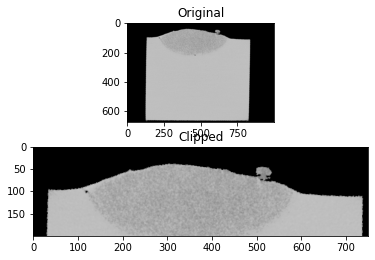

In [3]:
sample_addr = image_addr_list[100]
full_path = os.path.join(path, sample_addr)
imgobj = Image.open(full_path).convert('RGB')
# Show original images
img = np.asarray(imgobj)
ic(img.shape)
# Clip images
clipped_img = img[0:200,100:850]
ic(clipped_img.shape)
# Plot results
titles = ['Original', 'Clipped']
for idx, img in enumerate([img, clipped_img]):
    plt.subplot(2, 1,idx+1), plt.imshow(img,'gray',vmin=0,vmax=255)
    plt.title(titles[idx])

#### Clip all images

In [9]:
ic(len(image_addr_list))
process = True
if process:
    for i in tqdm(image_addr_list):
        full_path = os.path.join(path, i)
        img = Image.open(full_path).convert('RGB')
        img_array = np.asarray(img)
        img_ = Image.fromarray(img_array[0:250,120:850], 'RGB')
        img_.save('../Data/clipped/' + i)

ic| len(image_addr_list): 4046


  0%|          | 0/4046 [00:00<?, ?it/s]

In [8]:
len(image_addr_list)
len(os.listdir("../Data/clipped"))

0

In [5]:
assert len(os.listdir("../Data/clipped/")) == len(image_addr_list)

AssertionError: 

#### Denoising

##### Denoise a single sample image

In [80]:
import cv2 as cv

ic| clipped_img.shape: (200, 750, 3)
ic| thresh1.shape: (200, 750)
ic| ret: 0.0


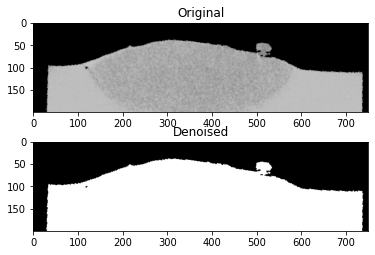

In [82]:
# Original images
ic(clipped_img.shape)
# plt.imshow(clipped_img)
# Thresholding the original images
bi_img = cv.cvtColor(clipped_img, cv.COLOR_BGR2GRAY)
ret, thresh1 = cv.threshold(bi_img, 255, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
ic(thresh1.shape)
ic(ret)
# Plot results
titles = ['Original', 'Denoised']
for idx, img in enumerate([clipped_img, thresh1]):
    plt.subplot(2, 1,idx+1), plt.imshow(img,'gray',vmin=0,vmax=255)
    plt.title(titles[idx])

##### Denoising all images

In [ ]:
process=False
if process:
    for i in tqdm(image_addr_list):
        full_path = os.path.join(path, i)
        img = Image.open(full_path).convert('RGB')
        img_array = np.asarray(img)
        # Clip
        img_ = Image.fromarray(img_array[0:250,120:850], 'RGB')
        img_ = cv.cvtColor(np.asarray(img_), cv.COLOR_BGR2GRAY)
        # Denoise
        ret, thresh1 = cv.threshold(img_, 255, 255, cv.THRESH_BINARY + cv.THRESH_OTSU) 
        Image.fromarray(thresh1).save('../Data/processed/' + i)
assert len(os.listdir("../Data/processed/")) == len(image_addr_list)

#### Find Contour & Bounding Boxes

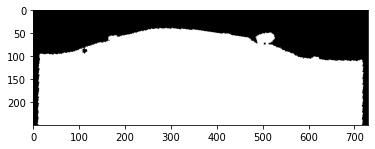

In [5]:
path = "../Data/processed/"
image_addr_list = os.listdir(path)
sample_addr = image_addr_list[250]
full_path = os.path.join(path, sample_addr)
imgobj = Image.open(full_path).convert('RGB')
# Show original images
raw_img = np.asarray(imgobj)
plt.imshow(raw_img)

In [6]:
import cv2 as cv
img0 = cv.cvtColor(raw_img,cv.COLOR_BGR2GRAY)
contours, hierarchy = cv.findContours(img0,cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)

ic| len(contours): 4
ic| item.shape: (601, 1, 2)
ic| item.shape: (8, 1, 2)
ic| item.shape: (6, 1, 2)
ic| item.shape: (4, 1, 2)


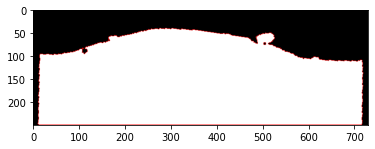

In [7]:
ic(len(contours))
for item in contours:
    ic(item.shape)
# plt.imshow(Image.fromarray(cv.drawContours(img0, contours,-1,(255,0,0),1)))
contour_img = Image.fromarray(cv.drawContours(raw_img, contours,-1,(255,0,0),1))
plt.imshow(contour_img)

ic| bb: (10, 39, 710, 211)
ic| bb: (502, 70, 6, 6)
ic| bb: (165, 64, 3, 4)
ic| bb: (164, 62, 3, 3)


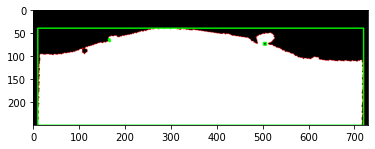

In [8]:
p = []
for item in contours:
    bb = cv.boundingRect(item)
    ic(bb)
    x,y,w,h = bb
    p.append(Image.fromarray(cv.rectangle(raw_img,(x,y),(x+w,y+h),(0,255,0),2)))
# Plot
plt.imshow(raw_img)


In [33]:
mask = np.ones(raw_img.shape[:2],dtype=np.uint8) * 255
cv.drawContours(mask, [contours[1]], -1, (0,255,255), -1)

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

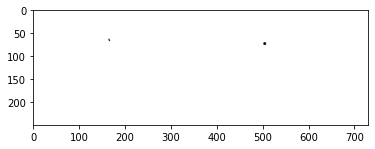

In [34]:
plt.imshow(cv.drawContours(mask, [contours[1], contours[2], contours[3]], -1, (0,255,255), -1),'gray')

##### Process all data with bounding boxes

In [ ]:
num_defects = []
min_area, max_area = 20, 20000
for i in tqdm(image_addr_list):
    full_path = os.path.join(path, i)
    imgobj = Image.open(full_path).convert('RGB')
    img = np.asarray(imgobj)
    # Convert to grayscale images
    grayimg = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    # Find contours
    contours, hierarchy = cv.findContours(grayimg,cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)

    num_poles = 0
    valid_contours = []
    # Loop through each contour to inspect
    for j in range(len(contours)):
        x, y, w, h = cv.boundingRect(contours[j])
        # Middle point must be black
        if grayimg[int(y+h/2), int(x+w/2)] == 0:
            # Pole can not be too close to the boundary
            if grayimg[int(max(y-h/2, 0)), int(x+w/2)] != 0:
                # Pole should be large enough
                if h*w > min_area:
                    num_poles += 1
    num_defects.append(num_poles)
    valid_contours.append(contours[j])
    # Save to processed
    mask = np.ones(raw_img.shape[:2],dtype=np.uint8) * 255
    img_arr = cv.drawContours(mask, valid_contours, -1, (0,255,255), -1)
    Image.fromarray(img_arr).save('../Data/final/' + i)